Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


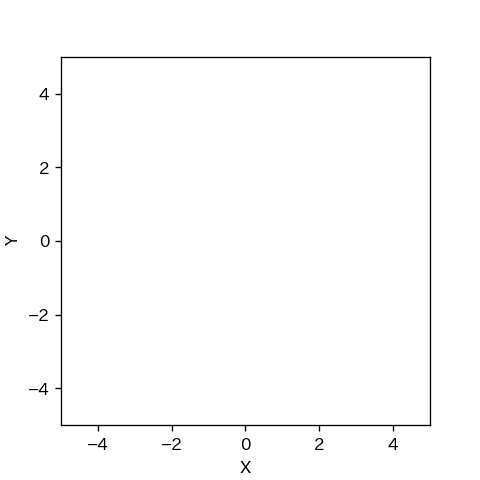

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

In [3]:
def trial_kidnap(animation): ###mclkidnap1test
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
    
    world.draw()
    
    return(r.pose, pf.ml.pose)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<IPython.core.display.Javascript object>


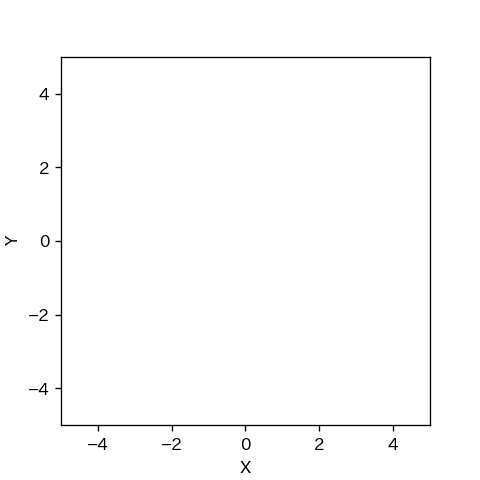

(array([-0.28752326,  4.81624473, -2.30413012]),
 array([-0.23678886,  0.81969139, -2.74988628]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.244322916719581]
0 真値: [2.19193894 1.33145435 2.53610401] 推定値: [2.4182341  1.45239133 8.79894098] 誤差: 0.256583806060555
1
[3.5045928284610772]
[4.049776523310112]
[6.038361850965402, 4.028683839979443]
1 真値: [-0.49675372  3.88156688  2.80631764] 推定値: [-0.64116773  4.3679534   2.90707551] 誤差: 0.5073728996128204
2
[2.6674529686330644]
[3.8599551013663755]
[5.848080455039061]
2 真値: [0.72263694 1.23025858 3.95614669] 推定値: [-4.62183015  6.55213916 -0.57992457] 誤差: 7.542263676701797
[4.9262431424794295]
3 真値: [-2.26968733 -0.99443536  3.14777706] 推定値: [-2.20882213 -0.43416693  3.24150657] 誤差: 0.563564803053646
3
[5.96367826524529]
[3.6463814876703604]
4 真値: [-0.81338942 -4.19069155  6.53470857] 推定値: [ 4.92281261 -2.58617364 -3.21982231] 誤差: 5.956382409420186
[4.38384166153133, 5.526862333810028]
5 真値: [3.04848088 1.98272939 7.58224817] 推定値: [3.43611946 2.24063844 1.71428628] 誤差: 0.4655971884443004
4
[1.0862414434306185]
6 真値: [2.12916958 2.77223796 4.36589102] 推定値: [1.78819187 2.62750698 

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[3.5127094914253134]
[5.201487360324901]
20 真値: [-3.50078389 -2.31803112  4.49497879] 推定値: [ 0.19624474  1.47701073 -0.42833241] 誤差: 5.2981471618632066
[1.8941467855903102]
21 真値: [1.13210015 5.08732174 3.95932148] 推定値: [4.46884093 4.42688972 2.71311277] 誤差: 3.4014716584908307
[3.4052655495199264]
22 真値: [2.48091887 0.45708547 4.55590491] 推定値: [2.86125095 0.5483736  4.43837303] 誤差: 0.3911342688995251
14
[3.390459455422016]
23 真値: [3.7949405  1.84564971 4.3155591 ] 推定値: [3.66155585 1.80680717 4.38660894] 誤差: 0.1389251856163726
15
[2.366234356519025]
24 真値: [-0.97069392  1.58485357  7.00610758] 推定値: [-1.15191388  1.50026274  0.74496511] 誤差: 0.1999907079725519
16
[5.643487845688896]
25 真値: [-2.73837731 -5.5941449   7.36826075] 推定値: [ 6.68500596 -5.5148115   3.22681496] 誤差: 9.42371720580335
[3.9431246762313354]
26 真値: [ 0.43565419 -0.01551806  6.1181333 ] 推定値: [ 0.55100697 -0.22020838  6.05696663] 誤差: 0.23495614410645133
17
[2.498393019775445]
[5.73145661115315]
27 真値: [ 2.65415583 -1.6028